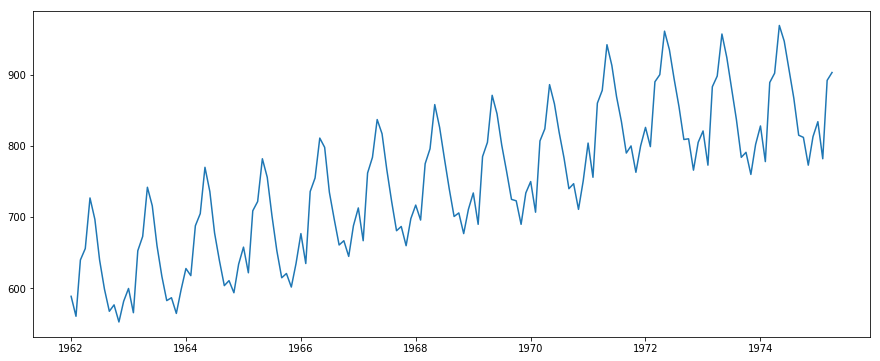

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 #set size of graph

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m') #set date format
data = pd.read_csv('monthly-milk-production-pounds-p (1).csv', parse_dates=['Month'], index_col='Month', nrows=160, date_parser = dateparse) #select month column
data = data.dropna() #remove NaN values

timeseries = data["Monthly milk production: pounds per cow. Jan 62 ? Dec 75"] #load milk production values
timeseries = timeseries.dropna() #drop any other NaN values (not sure why it is necessary to do it twice but an error was thrown)

plt.plot(timeseries) #plot the dates and milk production values so that we can see a trend


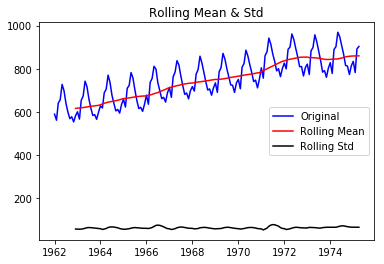

Results of D-F:
Test Statistic                  -1.518984
p-value                          0.524100
Number of Lags Used             13.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64


In [2]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(timeseries):
    
    rollingmean = timeseries.rolling(window=12).mean() #rolling mean of dates and milk produced
    rollingstd = timeseries.rolling(window=12).std() #std of ' '

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std')
    plt.show(block=False)
    
    #Perform DF test:
    print ('Results of D-F:')
    dataframetest = adfuller(timeseries, autolag='AIC')
    dataframeoutput = pd.Series(dataframetest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dataframetest[4].items():
        dataframeoutput['Critical Value (%s)'%key] = value
    print (dataframeoutput)
    
    #p-value>0.5 - non-stationary, else stationary 
    
testStationarity(timeseries) #test stationarity of dates and milk production


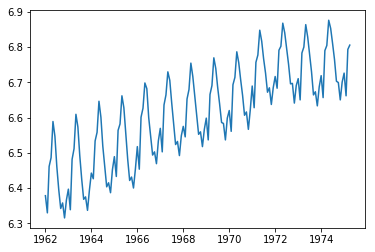

In [3]:
log_of_timeseries = np.log(timeseries)
plt.plot(log_of_timeseries) #plot log of the same timeseries


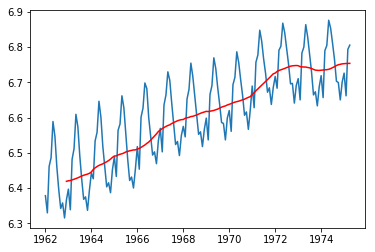

In [4]:
movingAverage = log_of_timeseries.rolling(window=12).mean()
movingSTD = log_of_timeseries.rolling(window=12).std()
plt.plot(log_of_timeseries)
plt.plot(movingAverage, color='red') #plot moving average of timeseries


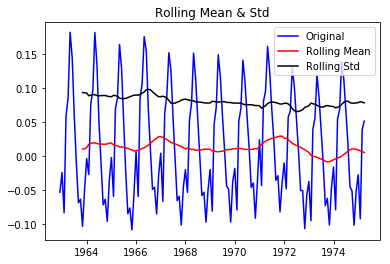

Results of D-F:
Test Statistic                  -2.973552
p-value                          0.037439
Number of Lags Used             13.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64


In [6]:
average_diff_of_logts = log_of_timeseries - movingAverage
average_diff_of_logts.head(12)
average_diff_of_logts.dropna(inplace=True)
testStationarity(average_diff_of_logts)

#stationary


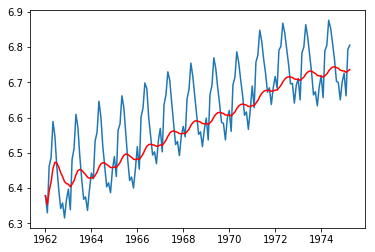

In [7]:
weighted_average_ed = log_of_timeseries.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(log_of_timeseries)
plt.plot(weighted_average_ed, color='red')

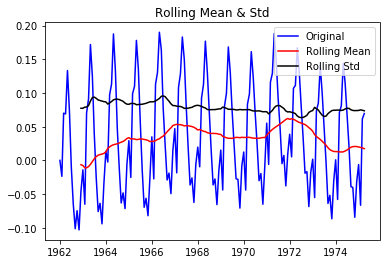

Results of D-F:
Test Statistic                  -3.779394
p-value                          0.003125
Number of Lags Used             13.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64


In [8]:
timeseries_log_ewma_diff = log_of_timeseries - weighted_average_ed

testStationarity(timeseries_log_ewma_diff)

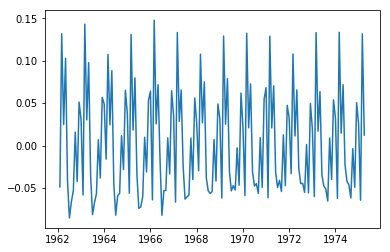

In [10]:
timeseries_log_diff = log_of_timeseries - log_of_timeseries.shift()
plt.plot(timeseries_log_diff)

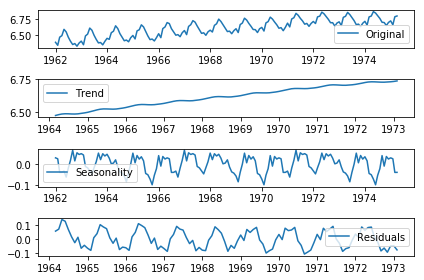

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_of_timeseries, freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_of_timeseries, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


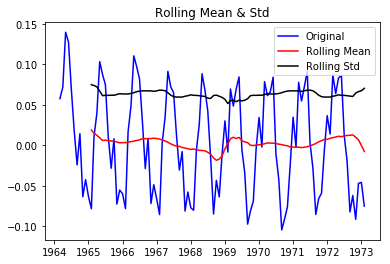

Results of D-F:
Test Statistic                 -2.703431
p-value                         0.073446
Number of Lags Used             8.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [13]:
log_timeseries_decompose = residual
log_timeseries_decompose.dropna(inplace=True)

testStationarity(log_timeseries_decompose)

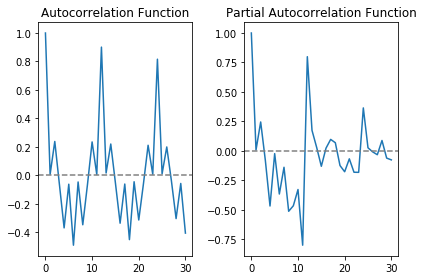

In [32]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf



timeseries_log_diff= timeseries_log_diff.dropna()
lag_acf = acf(timeseries_log_diff, nlags=30)
lag_pacf = pacf(timeseries_log_diff, nlags=30, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')

plt.title('Autocorrelation Function')            

#Plot Partial -ACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')

plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 
#Unsure of how to read these graphs to determine order values for generated models below

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: U

Text(0.5, 1.0, 'Residual Sum Squares: 0.5589')

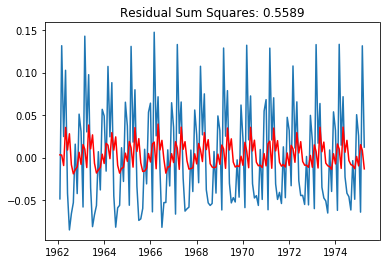

In [24]:
from statsmodels.tsa.arima_model import ARIMA  #Order values came from trial and error
#Auto
model = ARIMA(log_of_timeseries, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(timeseries_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual Sum Squares: %.4f'% sum((results_AR.fittedvalues-timeseries_log_diff)**2))



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual Sum Squares: 0.5183')

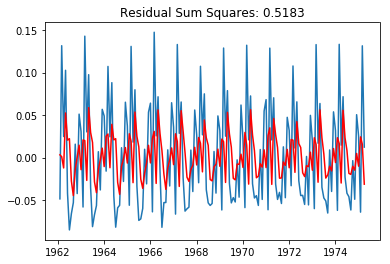

In [25]:
#moving average model
model = ARIMA(log_of_timeseries, order=(0, 1, 2)) 
results_AR = model.fit(disp=-1)  
plt.plot(timeseries_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual Sum Squares: %.4f'% sum((results_AR.fittedvalues-timeseries_log_diff)**2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual Sum Squares: 0.5190')

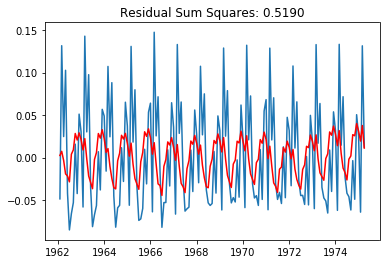

In [26]:

#arima
model = ARIMA(log_of_timeseries, order=(2, 1, 2)) 
results_AR = model.fit(disp=-1)  
plt.plot(timeseries_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual Sum Squares: %.4f'% sum((results_AR.fittedvalues-timeseries_log_diff)**2))

Month
1962-02-01    0.002385
1962-03-01    0.009676
1962-04-01    0.006165
1962-05-01   -0.013154
1962-06-01   -0.034915
1962-07-01   -0.063606
1962-08-01   -0.059757
1962-09-01   -0.050765
1962-10-01   -0.022443
1962-11-01   -0.001864
1962-12-01    0.027185
1963-01-01    0.048477
1963-02-01    0.057311
1963-03-01    0.079564
1963-04-01    0.077907
1963-05-01    0.056077
1963-06-01    0.026887
1963-07-01   -0.009847
1963-08-01   -0.012110
1963-09-01   -0.006327
1963-10-01    0.021938
1963-11-01    0.044797
1963-12-01    0.077540
1964-01-01    0.099850
1964-02-01    0.105895
1964-03-01    0.116395
1964-04-01    0.106075
1964-05-01    0.081487
1964-06-01    0.046101
1964-07-01    0.009089
                ...   
1972-11-01   -0.085915
1972-12-01   -0.059428
1973-01-01   -0.040045
1973-02-01   -0.032117
1973-03-01   -0.005450
1973-04-01   -0.006954
1973-05-01   -0.024979
1973-06-01   -0.047562
1973-07-01   -0.074348
1973-08-01   -0.075629
1973-09-01   -0.071230
1973-10-01   -0.041110
1973-

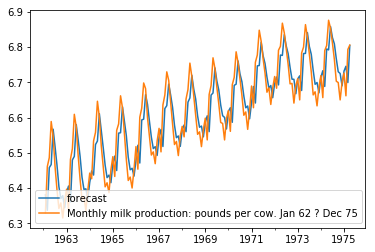

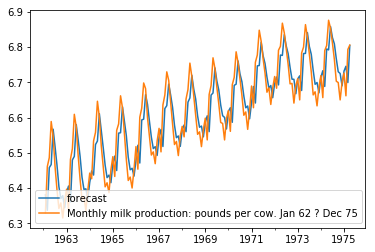

In [37]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

predictions_ARIMA_log = pd.Series(log_of_timeseries.iloc[0], index=timeseries.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)

results_AR.plot_predict() #plot arima forecast vs actual values